In [1]:
#%load_ext snakeviz
%matplotlib inline

In [2]:
#librerias utilitarias
from random import randint
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#librerias Keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils

Using TensorFlow backend.


In [4]:
from utils.multi_gpu import make_parallel

In [5]:
!nvidia-smi

Fri Jun 16 04:05:51 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.39                 Driver Version: 375.39                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 0000:00:17.0     Off |                    0 |
| N/A   62C    P0    62W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 0000:00:18.0     Off |                    0 |
| N/A   50C    P0    73W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

### Cargar Datos
___

In [36]:
train_data = sio.loadmat('data/train_32x32.mat')
test_data = sio.loadmat('data/test_32x32.mat')
X_train = train_data['X'].T
y_train = train_data['y'] - 1
X_test = test_data['X'].T
y_test = test_data['y'] - 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
n_classes = len(np.unique(y_train))
#print (np.unique(y_train))
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(73257, 3, 32, 32)
(26032, 3, 32, 32)
(73257, 10)
(26032, 10)


### Preparar paralelismo
___

Para parelizar la ejecución del modelo a nivel de datos se debe tener complir la siguiente relación:

$$ \frac{\frac{datos-de-entrenamiento}{batches}}{Nº GPU`s} = 0$$

Por quitamos 1 ejemplo de entreamiento y otro de test. 

In [37]:
Y_test_parallel =np.delete(Y_test, 1, 0)
X_test_parallel =np.delete(X_test, 1, 0)
Y_train_parallel =np.delete(Y_train, 1, 0)
X_train_parallel =np.delete(X_train, 1, 0)
print (X_train_parallel.shape)
print (X_test_parallel.shape)
print (Y_train_parallel.shape)
print (Y_test_parallel.shape)

(73256, 3, 32, 32)
(26031, 3, 32, 32)
(73256, 10)
(26031, 10)


Objetivo
-----
### Modelo
**(D)** Evalúe el efecto de modificar el tamaño de los filtros (de convolución y pooling) reportando la sensibilidad del error de pruebas a estos cambios. Presente un gráfico o tabla resumen. Por simplicidad entre durante sólo 10 epochs.

Con el fin de poder realizar las pruebas de distintas configuraciones de las arquitecturas a evaluar, se modularizo la creación de un modelo así también el entrenamiento de estos modelos en dos funciones que podemos ver a comunicación:

In [38]:
def createModelo(n_channels, n_rows, n_cols,_con_1,_con_2,_pooling):
    model = Sequential()
    model.add(Convolution2D(16, _con_1, _con_1, border_mode='same', activation='relu',
                        input_shape=(n_channels, n_rows, n_cols)))
    model.add(MaxPooling2D(pool_size=(_pooling, _pooling)))
    model.add(Convolution2D(512, _con_2, _con_2, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(_pooling, _pooling)))
    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    #model.summary()
    return model

Para verificar el comportamiento del comportamiento de las capas convolucionales y de pooling se probaron distintas configuraciones. En el caso de la Capa de pooling si bien, como se indico en clases, normalmente no se usan capas(filtros) para la reducción de dimensionalidad rara vez mayores de 2x2 en el caso de usar un filtro de 1x1 la GPU tiraba un problema de rama si que se opto por usar el segundo ejemplo de la capa de pooling con un tamaño de 3x3. 
, la configuración de los modelos la podemos ver en la siguiente tabla: 


<h3 align = 'center'> Modelos </h3>

|Nº|Capa convolucional 1 | Capa convolucional 2 |Capa de pooling 
| :-:| :-: | :-: | :-: | :-: |
|1|2|5|2| 
|2|2 |5|3|
|3|5 | 7 | 2| 
|4|5 | 7| 3 | 
|5|8 | 9 | 2 | 
|6|8 | 9 | 3 | 
|7|9 | 5 | 2 | 
|8|9 | 5 | 3 | 

In [39]:
#Parametros comunes
opt = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
_size, n_channels, n_rows, n_cols = X_train_parallel.shape
epochs = 10
#batch_size= 32
batch_size=1280

### Crear Modelos

In [47]:
#CASO 1
_con_1,_con_2,_pooling = 2,5,2
model_1 = createModelo(n_channels, n_rows, n_cols,_con_1,_con_2,_pooling)
model_1 = make_parallel(model_1, 8)
model_1.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (2, 2), activation="relu", input_shape=(3, 32, 32..., padding="same")`
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (5, 5), activation="relu", padding="same")`
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:46: UserWarning: Update

In [48]:
#CASO 2
_con_1,_con_2,_pooling = 2,5,3
model_2 = createModelo(n_channels, n_rows, n_cols,_con_1,_con_2,_pooling)
model_2 = make_parallel(model_2, 8)
model_2.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (2, 2), activation="relu", input_shape=(3, 32, 32..., padding="same")`
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (5, 5), activation="relu", padding="same")`
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:46: UserWarning: Update

In [49]:
#CASO 3
_con_1,_con_2,_pooling = 5,7,2
model_3 = createModelo(n_channels, n_rows, n_cols,_con_1,_con_2,_pooling)
model_3 = make_parallel(model_3, 8)
model_3.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", input_shape=(3, 32, 32..., padding="same")`
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (7, 7), activation="relu", padding="same")`
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:46: UserWarning: Update

In [50]:
#CASO 4
_con_1,_con_2,_pooling = 5,7,3
model_4 = createModelo(n_channels, n_rows, n_cols,_con_1,_con_2,_pooling)
model_4 = make_parallel(model_4, 8)
model_4.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", input_shape=(3, 32, 32..., padding="same")`
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (7, 7), activation="relu", padding="same")`
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:46: UserWarning: Update

In [51]:
#CASO 5
_con_1,_con_2,_pooling = 8,9,2
model_5 = createModelo(n_channels, n_rows, n_cols,_con_1,_con_2,_pooling)
model_5 = make_parallel(model_5, 8)
model_5.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), activation="relu", input_shape=(3, 32, 32..., padding="same")`
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (9, 9), activation="relu", padding="same")`
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:46: UserWarning: Update

In [52]:
#CASO 6
_con_1,_con_2,_pooling = 8,9,3
model_6 = createModelo(n_channels, n_rows, n_cols,_con_1,_con_2,_pooling)
model_6 = make_parallel(model_6, 8)
model_6.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), activation="relu", input_shape=(3, 32, 32..., padding="same")`
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (9, 9), activation="relu", padding="same")`
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:46: UserWarning: Update

In [53]:
#CASO 7
_con_1,_con_2,_pooling = 9,5,2
model_7 = createModelo(n_channels, n_rows, n_cols,_con_1,_con_2,_pooling)
model_7 = make_parallel(model_7, 8)
model_7.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (9, 9), activation="relu", input_shape=(3, 32, 32..., padding="same")`
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (5, 5), activation="relu", padding="same")`
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:46: UserWarning: Update

In [54]:
#CASO 8
_con_1,_con_2,_pooling = 9,5,3
model_8 = createModelo(n_channels, n_rows, n_cols,_con_1,_con_2,_pooling)
model_8 = make_parallel(model_8, 8)
model_8.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (9, 9), activation="relu", input_shape=(3, 32, 32..., padding="same")`
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (5, 5), activation="relu", padding="same")`
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:46: UserWarning: Update

### Fit Modelos y tiempos de entrenamiento
---

Solo considerando el tiempo de entremiento como indicador, podemos confirmar que modelos con mayor tamaño de  filtros en las capas convolución implican mayor tiempo de entrenamiento. Por otro lado aumentar el tamaño del pooling reduce estos tiempos, esto tiene sentido por la reducción de dimencionalidad. En caso del modelo 2 es el que presenta menores tiempos de entremiento **5min 20s**, que tiene la misma arquitectura del modelo 1, pero la capa de pooling es mayor, este cambio redujo los tiempos de entreamiento en casi 3 minutos.

Lo anterior lo podemos ver la siguiente tabla:

<h3 align = 'center'> Tiempo de entrenamiento Modelos </h3>

|Nº|Capa convolucional 1 | Capa convolucional 2 |Capa de pooling |Entrenamiento|
| :-:| :-: | :-: | :-: | :-: |:-: |
|1|2|5|2| 8min 46s|
|**2**|**2** |**5**|**3**|**5min 20s**|
|3|5 | 7 | 2|8min 50s |
|4|5 | 7| 3 | 5min 35s|
|5|8 | 9 | 2 | 9min 33s|
|6|8 | 9 | 3 | 6min 20s|
|7|9 | 5 | 2 |9min 34s |
|8|9 | 5 | 3 | 5min 28s|

In [55]:
%%time
history_caso_1 = model_1.fit(X_train_parallel, Y_train_parallel, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_data=(X_test, Y_test))

CPU times: user 6min 22s, sys: 2min 23s, total: 8min 46s
Wall time: 1min 51s


In [56]:
%%time
history_caso_2 = model_2.fit(X_train_parallel, Y_train_parallel, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_data=(X_test, Y_test))

CPU times: user 3min 50s, sys: 1min 29s, total: 5min 20s
Wall time: 1min 4s


In [57]:
%%time
history_caso_3 = model_3.fit(X_train_parallel, Y_train_parallel, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_data=(X_test, Y_test))

CPU times: user 6min 21s, sys: 2min 28s, total: 8min 50s
Wall time: 1min 52s


In [58]:
%%time
history_caso_4 = model_4.fit(X_train_parallel, Y_train_parallel, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_data=(X_test, Y_test))

CPU times: user 4min, sys: 1min 35s, total: 5min 35s
Wall time: 1min 14s


In [59]:
%%time
history_caso_5 = model_5.fit(X_train_parallel, Y_train_parallel, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_data=(X_test, Y_test))

CPU times: user 6min 54s, sys: 2min 38s, total: 9min 33s
Wall time: 2min 11s


In [60]:
%%time
history_caso_6 = model_6.fit(X_train_parallel, Y_train_parallel, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_data=(X_test, Y_test))

CPU times: user 4min 30s, sys: 1min 49s, total: 6min 20s
Wall time: 1min 15s


In [61]:
%%time
history_caso_7 = model_7.fit(X_train_parallel, Y_train_parallel, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_data=(X_test, Y_test))

CPU times: user 6min 56s, sys: 2min 37s, total: 9min 34s
Wall time: 2min 12s


In [62]:
%%time
history_caso_8 = model_8.fit(X_train_parallel, Y_train_parallel, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_data=(X_test, Y_test))

CPU times: user 3min 55s, sys: 1min 32s, total: 5min 28s
Wall time: 1min 7s


### Graficos de curvas
---


Como poder ver en grafico generado como resultado de la aplicación de 8 modelos, que podemos ver resumidos en la siguiente tablas: 




|Nº|Capa convolucional 1 | Capa convolucional 2 |Capa de pooling 
| :-:| :-: | :-: | :-: | :-: | 
|1|2 |5|2|
|4|5 | 7 | 3| 
|5|8 | 9| 2 | 


Como parte del entrenamiento se guardaron todos los modelos, por lo que ahora habiendo encontrado los modelos que presentan una tasa de perdida que indica  una convergencia a valores menores en el caso 5 esta caída es demasiado irrgular, en los casos 1 y 4 se ve un comportamiento mas estable.

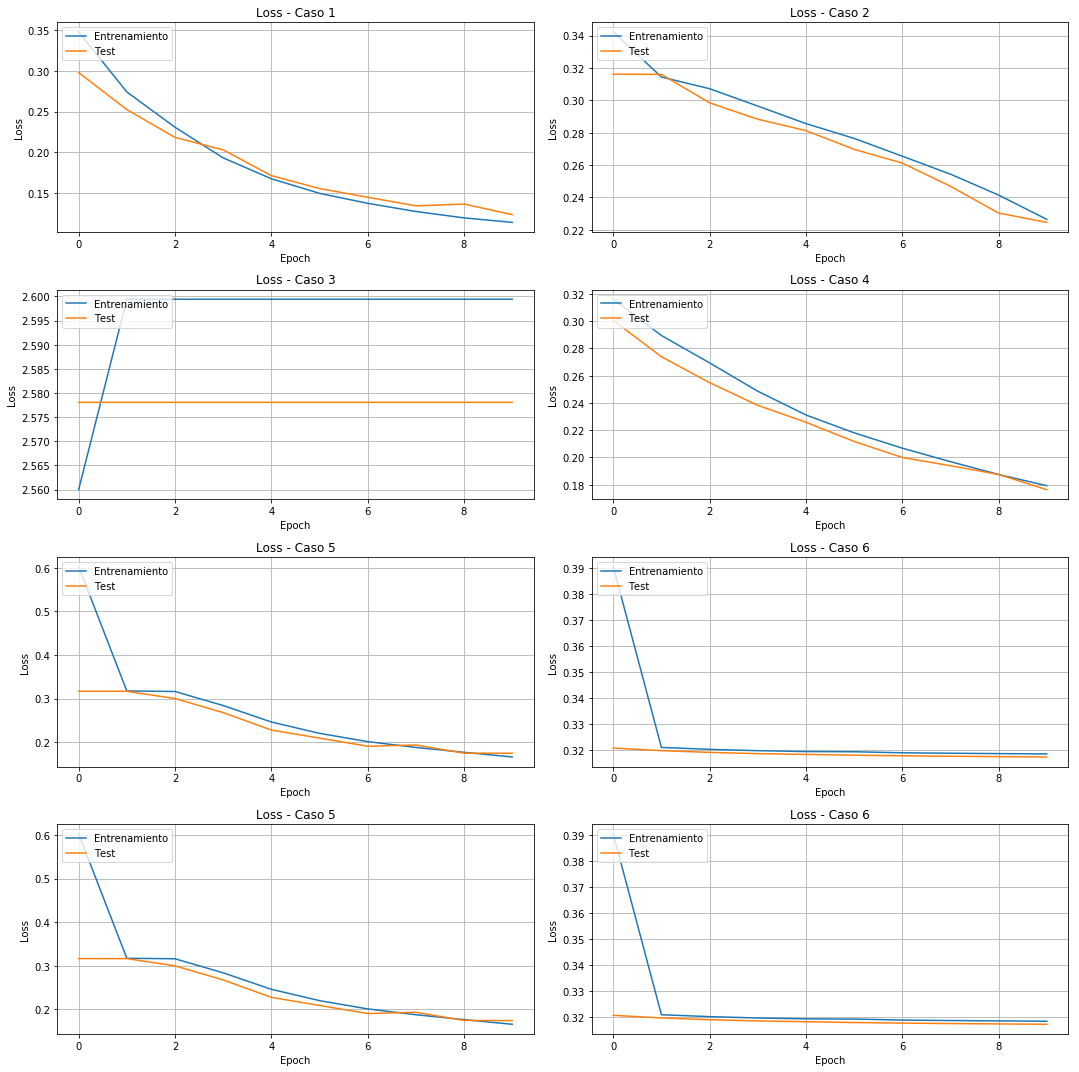

In [75]:
plt.figure(figsize=(15, 15))
plt.subplot(4, 2, 1)
plt.plot(history_caso_1.history['loss'])  
plt.plot(history_caso_1.history['val_loss'])  
plt.title('Loss - Caso 1')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')  
plt.grid(True)

plt.subplot(4, 2, 2)
plt.plot(history_caso_2.history['loss'])  
plt.plot(history_caso_2.history['val_loss'])  
plt.title('Loss - Caso 2')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(4, 2, 3)
plt.plot(history_caso_3.history['loss'])  
plt.plot(history_caso_3.history['val_loss'])  
plt.title('Loss - Caso 3')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')  
plt.grid(True)

plt.subplot(4, 2, 4)
plt.plot(history_caso_4.history['loss'])  
plt.plot(history_caso_4.history['val_loss'])  
plt.title('Loss - Caso 4')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(4, 2, 5)
plt.plot(history_caso_5.history['loss'])  
plt.plot(history_caso_5.history['val_loss'])  
plt.title('Loss - Caso 5')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')  
plt.grid(True)

plt.subplot(4, 2, 6)
plt.plot(history_caso_6.history['loss'])  
plt.plot(history_caso_6.history['val_loss'])  
plt.title('Loss - Caso 6')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(4, 2, 7)
plt.plot(history_caso_5.history['loss'])  
plt.plot(history_caso_5.history['val_loss'])  
plt.title('Loss - Caso 5')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')  
plt.grid(True)

plt.subplot(4, 2, 8)
plt.plot(history_caso_6.history['loss'])  
plt.plot(history_caso_6.history['val_loss'])  
plt.title('Loss - Caso 6')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

### Evaluar modelos
---

In [77]:
#%%time
scores_1 = model_1.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo Caso 1: %.2f%%" % (scores_1[1]*100))
print("Loss del modelo Caso 1: %.2f%%" % (scores_1[0]*100))
scores_2 = model_2.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo Caso 2: %.2f%%" % (scores_2[1]*100))
print("Loss del modelo Caso 2: %.2f%%" % (scores_2[0]*100))
scores_3 = model_3.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo Caso 3: %.2f%%" % (scores_3[1]*100))
print("Loss del modelo Caso 3: %.2f%%" % (scores_3[0]*100))
scores_4 = model_4.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo Caso 4: %.2f%%" % (scores_4[1]*100))
print("Loss del modelo Caso 4: %.2f%%" % (scores_4[0]*100))
scores_5 = model_5.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo Caso 5: %.2f%%" % (scores_5[1]*100))
print("Loss del modelo Caso 5: %.2f%%" % (scores_5[0]*100))
scores_6 = model_6.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo Caso 6: %.2f%%" % (scores_6[1]*100))
print("Loss del modelo Caso 6: %.2f%%" % (scores_6[0]*100))
scores_7 = model_7.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo Caso 7: %.2f%%" % (scores_7[1]*100))
print("Loss del modelo Caso 7: %.2f%%" % (scores_7[0]*100))
scores_8 = model_8.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo Caso 8: %.2f%%" % (scores_8[1]*100))
print("Loss del modelo Caso 8: %.2f%%" % (scores_8[0]*100))

25984/26032 [============================>.] - ETA: 0s 

<h3 align = 'center'> Comparación del accuracy </h3>

Si bien en tiempos de entrenamiento el modelo 2 presentaba mejor resultados que el modelo 1, esto al momento de comparar el accuracy parece que el aumento de tamaño de la capa de pooling tiene un efecto contrario. Esto al comparar el performance de 95.79% del modelo 1 versus el 92.06% del modelo 2. Acá podemos ver trade-off entre tiempo de entrenamiento y precisión 

|Nº|Capa convolucional 1 | Capa convolucional 2 |Capa de pooling |Entrenamiento|Accuracy|
| :-:| :-: | :-: | :-: | :-: |:-: |:-: |
|1|2|5|2| 8min 46s|**95.79%**|
|2|2 |5|3|5min 20s|92.06%|
|3|5 | 7 | 2|8min 50s |83.92%|
|4|5 | 7| 3 | 5min 35s|93.24%|
|5|8 | 9 | 2 | 9min 33s|94.08%|
|6|8 | 9 | 3 | 6min 20s|90.00%|
|7|9 | 5 | 2 |9min 34s |93.05%|
|8|9 | 5 | 3 | 5min 28s|90.92%|